In [4]:
# Standard imports
import sys
import os
import glob
import pandas as pd
import numpy as np
import textwrap
import matplotlib.pyplot as plt
%matplotlib inline

# ML
import tensorflow_hub as hub
import tensorflow as tf

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
SEED=1

# Plotly
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
import plotly.io as pio
init_notebook_mode(connected=True)

def matplotlib_to_plotly(cmap, pl_entries):
    h = 1.0/(pl_entries-1)
    pl_colorscale = []

    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])

    return pl_colorscale

# Cell timing
# https://github.com/cpcloud/ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 39.1 ms


In [6]:
# Opiniosis
# https://github.com/kavgan/opinosis

# Unzip the topic ZIP file in /data/topics and put the .txt.data files into /data/topics

# Read in the topics file, and create lists of topic names and text
topic_datasets = glob.glob('data/topics/*.txt.data')
topic_datasets.sort()
topics, reviews = [], []
for topic_file in topic_datasets:
    r = open(topic_file, 'r', encoding='latin1').readlines()
    t = [topic_file] * len(r)
    topics = topics + t
    reviews = reviews + [rr.strip() for rr in r]
    
# Convert the two lists into a df
df = pd.DataFrame(data={'topic':topics, 'text':reviews})
sentences = df.text.tolist()

time: 51.6 ms


In [14]:
df['textwrap'] = df.text.map(lambda x: '<br>'.join(textwrap.wrap(x, 64)))

time: 289 ms


In [18]:
# Load Google model from Tensorflow Hub
guse = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-large/3")

# Function which will take a list of strings (sentences) and return the GUSE vectors
def guse_vectors(x):
  embeddings = guse(x)
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    return sess.run(embeddings)

time: 5min 32s


In [19]:
# Generate GUSE vectors - batch process 1000 at a time
batch_size = 2000
sentences_batch = [sentences[i:i+batch_size] for i in range(0,len(sentences),batch_size)]
vectors_guse_batch = [guse_vectors(x) for x in sentences_batch]
vectors_guse = np.concatenate(vectors_guse_batch, axis=0)

time: 4min 38s


In [20]:
np.save('output/vectors-opiniosis.npy', vectors_guse)

time: 65.3 ms


In [21]:
embedding_pca = PCA(n_components=2).fit_transform(vectors_guse)

time: 79.5 ms


In [22]:
embedding_tsne = TSNE(n_components=2, random_state=SEED).fit_transform(vectors_guse)

time: 3min 29s


In [23]:
embedding_umap = umap.UMAP(n_components=2, random_state=SEED).fit_transform(vectors_guse)

time: 16.8 s


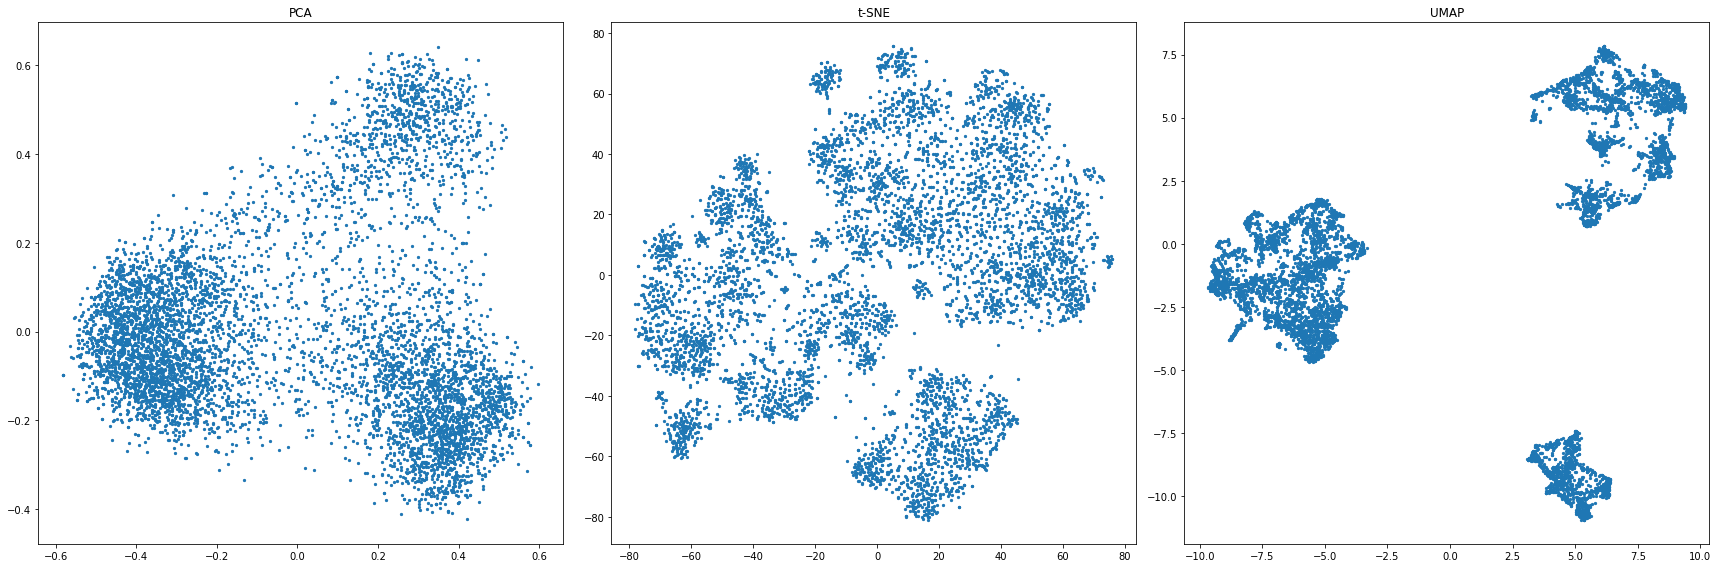

time: 1.15 s


In [24]:
# Comparison of dimension reduction methods
s = 5

plt.figure(figsize=(24,8), facecolor='w')

plt.subplot(131)
plt.scatter(embedding_pca[:,0], embedding_pca[:,1], s=s)
plt.title('PCA')

plt.subplot(132)
plt.scatter(embedding_tsne[:,0], embedding_tsne[:,1], s=s)
plt.title('t-SNE')

plt.subplot(133)
plt.scatter(embedding_umap[:,0], embedding_umap[:,1], s=s)
plt.title('UMAP')

plt.tight_layout()
plt.show()

In [25]:
x = umap.UMAP(n_components=2, metric='cosine', random_state=SEED).fit_transform(vectors_guse)

time: 16.2 s


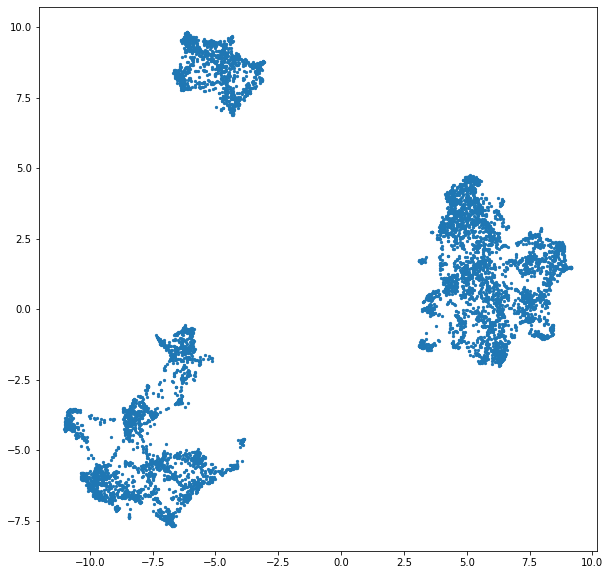

time: 298 ms


In [26]:
plt.figure(figsize=(10,10))
plt.scatter(x[:,0], x[:,1], s=s)
plt.show()

In [27]:
df['x'] = embedding_umap[:,0]
df['y'] = embedding_umap[:,1]
df[['topic','text','textwrap','x','y']].to_csv('output/data-opiniosis.txt', sep='\t', index=False)

time: 71.3 ms


In [28]:
nns = [2, 5, 10, 100, 500]
mds = [0.0, 0.1, 0.25, 0.5, 0.8, 0.99]

embedding_umap_hyper = []
for n_neighbours in nns:
    for min_dist in mds:
        embedding_umap_hyper.append(umap.UMAP(n_components=2,
                                              n_neighbors=n_neighbours,
                                              min_dist=min_dist,
                                              random_state=SEED).fit_transform(vectors_guse))

/anaconda/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 814 separate connected components using meta-embedding (experimental)

/anaconda/lib/python3.6/site-packages/scipy/sparse/csgraph/_laplacian.py:72: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.

/anaconda/lib/python3.6/site-packages/umap/spectral.py:182: UserWarning:

failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!

/anaconda/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning:

Embedding a total of 814 separate connected components using meta-embedding (experimental)

/anaconda/lib/python3.6/site-packages/scipy/sparse/csgraph/_laplacian.py:72: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In 

time: 11min 11s


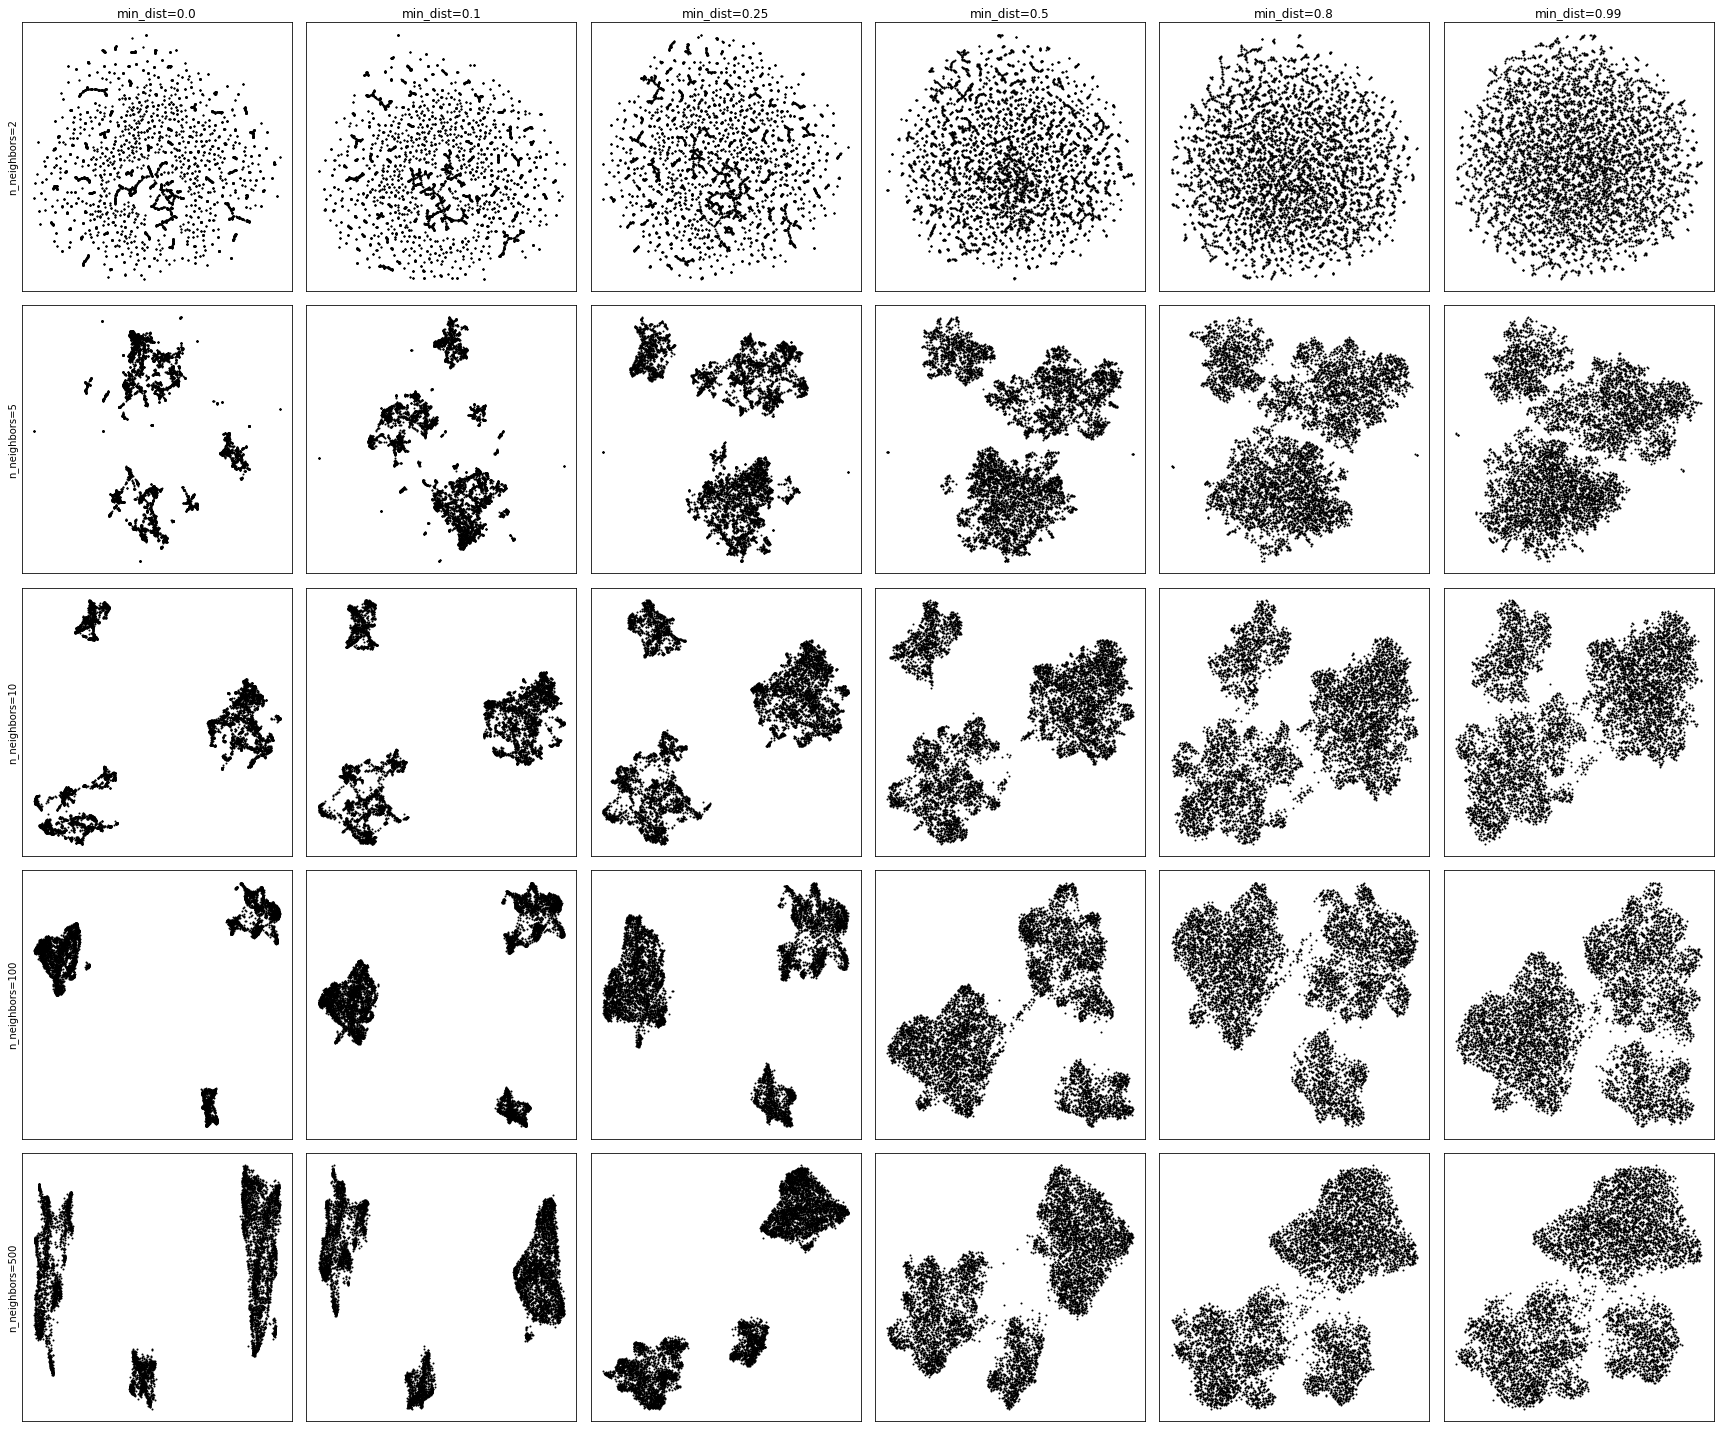

time: 2.65 s


In [29]:
plt.figure(figsize=(24,20))

for i in range(len(embedding_umap_hyper)):
    plt.subplot(5,6,i+1)
    plt.scatter(embedding_umap_hyper[i][:,0],embedding_umap_hyper[i][:,1], s=1, c='k')
    plt.xticks([],[])
    plt.yticks([],[])
    if i <= 5:
        plt.title('min_dist={}'.format(mds[i]))
    if i % 6 == 0:
        plt.ylabel('n_neighbors={}'.format(nns[int(i/6)]))
        
plt.tight_layout()
plt.show()

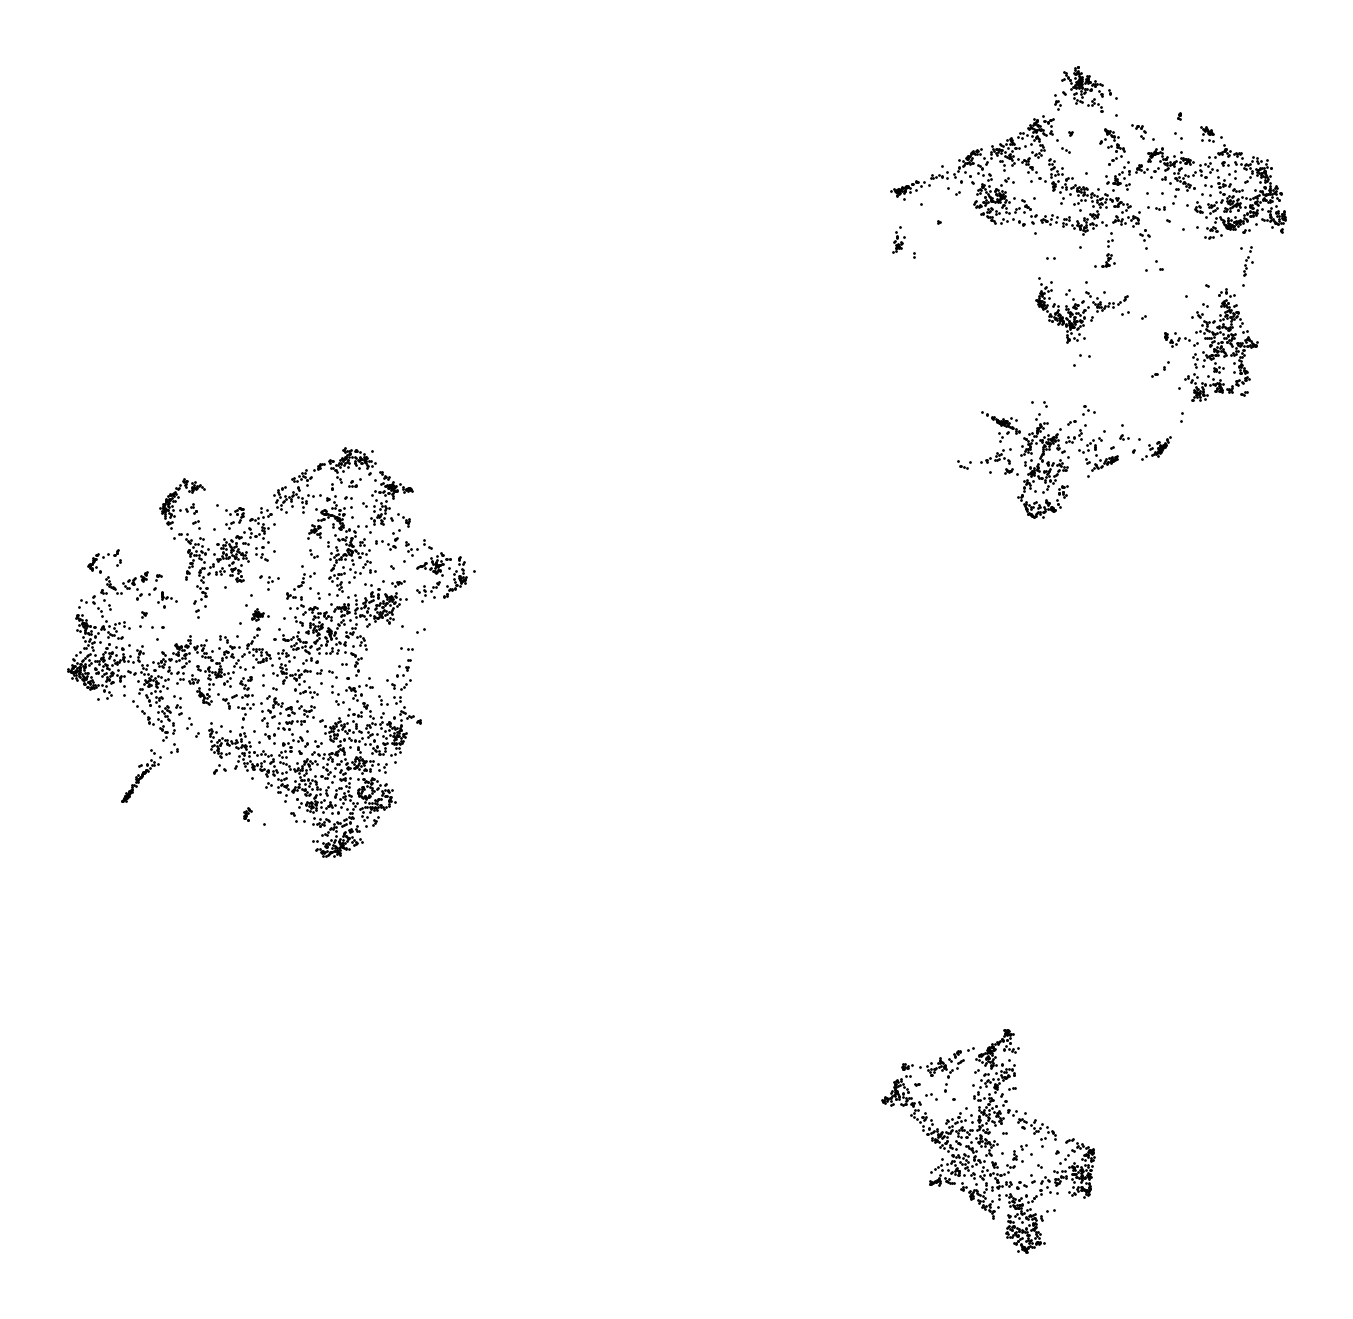

time: 790 ms


In [30]:
# Plot for presentation
plt.figure(figsize=(24,24), facecolor='w')
plt.scatter(embedding_umap[:,0], embedding_umap[:,1],s=3,c='k')
plt.axis('off')
plt.show()

In [31]:
# Plotly version for manual topic discovery
layout = go.Layout(
    autosize=False,
    width=800,
    height=800,
    hovermode="closest"
)

data = [go.Scatter(
                x=embedding_umap[:,0],
                y=embedding_umap[:,1],
                text=df.textwrap,
                mode='markers',
                marker=dict(
                        size=5,
                        colorscale=matplotlib_to_plotly(plt.cm.tab20b, 255),
                        color=0,#df.topic_id,
                        showscale=False
                )
)]

fig = go.Figure(data=data, layout=layout)

p = iplot(fig)

time: 671 ms


In [33]:
# Save this version, for github &  workshop
plot(fig, filename='output/viz3-opinosis.html')

'output/viz3-opinosis.html'

time: 312 ms
